Logistic Regression with L2 regularization
The goal of this second notebook is to implement your own logistic regression classifier with L2 regularization. You will do the following:

Extract features from Amazon product reviews.
Convert an SFrame into a NumPy array.
Write a function to compute the derivative of log likelihood function with an L2 penalty with respect to a single coefficient.
Implement gradient ascent with an L2 penalty.
Empirically explore how the L2 penalty can ameliorate overfitting.
Fire up GraphLab Create
Make sure you have the latest version of GraphLab Create. Upgrade by

   pip install graphlab-create --upgrade

In [1]:
from __future__ import division
import graphlab

Load and process review dataset

In [2]:
products = graphlab.SFrame('amazon_baby_subset.gl/')

This non-commercial license of GraphLab Create is assigned to gautam.karmakar@gmail.com and will expire on March 28, 2017. For commercial licensing options, visit https://dato.com/buy/.


2016-04-08 12:01:56,144 [INFO] graphlab.cython.cy_server, 176: GraphLab Create v1.8.5 started. Logging: C:\Users\ritraina\AppData\Local\Temp\graphlab_server_1460142109.log.0


Remove the punctuation and compute the word counts

In [3]:
# The same feature processing (same as the previous assignments)
# ---------------------------------------------------------------
import json
with open('important_words.json', 'r') as f: # Reads the list of most frequent words
    important_words = json.load(f)
important_words = [str(s) for s in important_words]


def remove_punctuation(text):
    import string
    return text.translate(None, string.punctuation) 

# Remove punctuation.
products['review_clean'] = products['review'].apply(remove_punctuation)

# Split out the words into individual columns
for word in important_words:
    products[word] = products['review_clean'].apply(lambda s : s.split().count(word))

In [4]:
products

name,review,rating,sentiment,review_clean,baby
Stop Pacifier Suckingwithout tears with ...,All of my kids have criednon-stop when I tried to ...,5.0,1,All of my kids have criednonstop when I tried to ...,0
Nature's Lullabies SecondYear Sticker Calendar ...,We wanted to getsomething to keep track ...,5.0,1,We wanted to getsomething to keep track ...,0
Nature's Lullabies SecondYear Sticker Calendar ...,My daughter had her 1stbaby over a year ago. ...,5.0,1,My daughter had her 1stbaby over a year ago She ...,1
"Lamaze Peekaboo, I LoveYou ...","One of baby's first andfavorite books, and i ...",4.0,1,One of babys first andfavorite books and it is ...,0
SoftPlay Peek-A-BooWhere's Elmo A Childr ...,Very cute interactivebook! My son loves this ...,5.0,1,Very cute interactivebook My son loves this ...,0
Our Baby Girl Memory Book,"Beautiful book, I love itto record cherished t ...",5.0,1,Beautiful book I love itto record cherished t ...,0
Hunnt&reg; FallingFlowers and Birds Kids ...,"Try this out for a springproject !Easy ,fun and ...",5.0,1,Try this out for a springproject Easy fun and ...,0
Blessed By Pope BenedictXVI Divine Mercy Full ...,very nice Divine MercyPendant of Jesus now on ...,5.0,1,very nice Divine MercyPendant of Jesus now on ...,0
Cloth Diaper PinsStainless Steel ...,We bought the pins as my6 year old Autistic son ...,4.0,1,We bought the pins as my6 year old Autistic son ...,0
Cloth Diaper PinsStainless Steel ...,It has been many yearssince we needed diaper ...,5.0,1,It has been many yearssince we needed diaper ...,0


Train-Validation split
We split the data into a train-validation split with 80% of the data in the training set and 20% of the data in the validation set. We use seed=2 so that everyone gets the same result.
Note: In previous assignments, we have called this a train-test split. However, the portion of data that we don't train on will be used to help select model parameters. Thus, this portion of data should be called a validation set. Recall that examining performance of various potential models (i.e. models with different parameters) should be on a validation set, while evaluation of selected model should always be on a test set.

In [5]:
train_data, validation_data = products.random_split(.8, seed=2)

print 'Training set   : %d data points' % len(train_data)
print 'Validation set : %d data points' % len(validation_data)

Training set   : 42361 data points
Validation set : 10711 data points


In [6]:
#Convert SFrame to NumPy array
import numpy as np

def get_numpy_data(data_sframe, features, label):
    data_sframe['intercept'] = 1
    features = ['intercept'] + features
    features_sframe = data_sframe[features]
    feature_matrix = features_sframe.to_numpy()
    label_sarray = data_sframe[label]
    label_array = label_sarray.to_numpy()
    return(feature_matrix, label_array)

In [7]:
feature_matrix_train, sentiment_train = get_numpy_data(train_data, important_words, 'sentiment')
feature_matrix_valid, sentiment_valid = get_numpy_data(validation_data, important_words, 'sentiment') 

Building on logistic regression with no L2 penalty assignment
Let us now build on Module 3 assignment. Recall from lecture that the link function for logistic regression can be defined as:
P(yi=+1|xi,w)=1/(1+exp(−wTh(xi)),
where the feature vector h(xi) is given by the word counts of important_words in the review xi.
We will use the same code as in this past assignment to make probability predictions since this part is not affected by the L2 penalty. (Only the way in which the coefficients are learned is affected by the addition of a regularization term.)

In [8]:
"""
produces probablistic estimate for P(y_i = +1 | x_i, w).
estimate ranges between 0 and 1.
"""
def predict_probability(feature_matrix, coefficients):
    # Take dot product of feature_matrix and coefficients  
    scores = np.dot(feature_matrix,coefficients)
    
    # Compute P(y_i = +1 | x_i, w) using the link function
    
    predictions = 1/(1+np.exp(-scores))
    
    return predictions

Adding L2 penalty
Let us now work on extending logistic regression with L2 regularization. As discussed in the lectures, the L2 regularization is particularly useful in preventing overfitting. In this assignment, we will explore L2 regularization in detail.
Recall from lecture and the previous assignment that for logistic regression without an L2 penalty, the derivative of the log likelihood function is:
∂ℓ∂wj=∑i=1Nhj(xi)(1[yi=+1]−P(yi=+1|xi,w))
Adding L2 penalty to the derivative
It takes only a small modification to add a L2 penalty. All terms indicated in red refer to terms that were added due to an L2 penalty.
Recall from the lecture that the link function is still the sigmoid:
P(yi=+1|xi,w)=11+exp(−wTh(xi)),
We add the L2 penalty term to the per-coefficient derivative of log likelihood:
∂ℓ/∂wj=∑i=1Nhj(xi)(1[yi=+1]−P(yi=+1|xi,w))−2λwj
The per-coefficient derivative for logistic regression with an L2 penalty is as follows:
∂ℓ/∂wj=∑i=1Nhj(xi)(1[yi=+1]−P(yi=+1|xi,w))−2λwj
and for the intercept term, we have
∂ℓ/∂w0=∑i=1Nh0(xi)(1[yi=+1]−P(yi=+1|xi,w))
Note: As we did in the Regression course, we do not apply the L2 penalty on the intercept. A large intercept does not necessarily indicate overfitting because the intercept is not associated with any particular feature.
Write a function that computes the derivative of log likelihood with respect to a single coefficient wj. Unlike its counterpart in the last assignment, the function accepts five arguments:
errors vector containing (1[yi=+1]−P(yi=+1|xi,w)) for all i
feature vector containing hj(xi) for all i
coefficient containing the current value of coefficient wj.
l2_penalty representing the L2 penalty constant λ
feature_is_constant telling whether the j-th feature is constant or not.

In [9]:
def feature_derivative_with_L2(errors, feature, coefficient, l2_penalty, feature_is_constant): 
    
    # Compute the dot product of errors and feature
    
    derivative = np.dot(errors,feature)

    # add L2 penalty term for any feature that isn't the intercept.
    if not feature_is_constant: 
       derivative = derivative + l2_penaulty
        
    return derivative

In [10]:
def compute_log_likelihood_with_L2(feature_matrix, sentiment, coefficients, l2_penalty):
    indicator = (sentiment==+1)
    scores = np.dot(feature_matrix, coefficients)
    
    lp = np.sum((indicator-1)*scores - np.log(1. + np.exp(-scores))) - l2_penalty*np.sum(coefficients[1:]**2)
    
    return lp

In [11]:
def logistic_regression_with_L2(feature_matrix, sentiment, initial_coefficients, step_size, l2_penalty, max_iter):
    coefficients = np.array(initial_coefficients) # make sure it's a numpy array
    for itr in xrange(max_iter):
        # Predict P(y_i = +1|x_i,w) using your predict_probability() function
        
        predictions = predict_probability(feature_matrix, coefficients)
        
        # Compute indicator value for (y_i = +1)
        indicator = (sentiment==+1)
        
        # Compute the errors as indicator - predictions
        errors = indicator - predictions
        for j in xrange(len(coefficients)): # loop over each coefficient
            is_intercept = (j == 0)
            if is_intercept:
                feature_is_constant = True
            # Recall that feature_matrix[:,j] is the feature column associated with coefficients[j].
            # Compute the derivative for coefficients[j]. Save it in a variable called derivative
            feature = feature_matrix[:,j]
            coefficient = coefficients[j]
            derivative = feature_derivative_with_L2(errors, feature, coefficient, l2_penalty, feature_is_constant)
            
            # add the step size times the derivative to the current coefficient
            coefficients[j]= coefficients[j] + step_size*derivative
        
        # Checking whether log likelihood is increasing
        if itr <= 15 or (itr <= 100 and itr % 10 == 0) or (itr <= 1000 and itr % 100 == 0) \
        or (itr <= 10000 and itr % 1000 == 0) or itr % 10000 == 0:
            lp = compute_log_likelihood_with_L2(feature_matrix, sentiment, coefficients, l2_penalty)
            print 'iteration %*d: log likelihood of observed labels = %.8f' % \
                (int(np.ceil(np.log10(max_iter))), itr, lp)
    return coefficients

In [12]:
# run with L2 = 0
coefficients_0_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                     initial_coefficients=np.zeros(194),
                                                     step_size=5e-6, l2_penalty=0, max_iter=501)

iteration   0: log likelihood of observed labels = -29179.39138303
iteration   1: log likelihood of observed labels = -29003.71259047
iteration   2: log likelihood of observed labels = -28834.66187288
iteration   3: log likelihood of observed labels = -28671.70781507
iteration   4: log likelihood of observed labels = -28514.43078198
iteration   5: log likelihood of observed labels = -28362.48344665
iteration   6: log likelihood of observed labels = -28215.56713122
iteration   7: log likelihood of observed labels = -28073.41743783
iteration   8: log likelihood of observed labels = -27935.79536396
iteration   9: log likelihood of observed labels = -27802.48168669
iteration  10: log likelihood of observed labels = -27673.27331484
iteration  11: log likelihood of observed labels = -27547.98083656
iteration  12: log likelihood of observed labels = -27426.42679977
iteration  13: log likelihood of observed labels = -27308.44444728
iteration  14: log likelihood of observed labels = -27193.8767

In [13]:
# run with L2 = 4
coefficients_4_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                      initial_coefficients=np.zeros(194),
                                                      step_size=5e-6, l2_penalty=4, max_iter=501)

iteration   0: log likelihood of observed labels = -29179.39508175
iteration   1: log likelihood of observed labels = -29003.72707754
iteration   2: log likelihood of observed labels = -28834.69381939
iteration   3: log likelihood of observed labels = -28671.76351833
iteration   4: log likelihood of observed labels = -28514.51619917
iteration   5: log likelihood of observed labels = -28362.60422152
iteration   6: log likelihood of observed labels = -28215.72861613
iteration   7: log likelihood of observed labels = -28073.62471272
iteration   8: log likelihood of observed labels = -27936.05325307
iteration   9: log likelihood of observed labels = -27802.79477371
iteration  10: log likelihood of observed labels = -27673.64595674
iteration  11: log likelihood of observed labels = -27548.41717641
iteration  12: log likelihood of observed labels = -27426.93077868
iteration  13: log likelihood of observed labels = -27309.01981552
iteration  14: log likelihood of observed labels = -27194.5270

In [14]:
# run with L2 = 10
coefficients_10_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                      initial_coefficients=np.zeros(194),
                                                      step_size=5e-6, l2_penalty=10, max_iter=501)

iteration   0: log likelihood of observed labels = -29179.40062984
iteration   1: log likelihood of observed labels = -29003.74880814
iteration   2: log likelihood of observed labels = -28834.74173916
iteration   3: log likelihood of observed labels = -28671.84707321
iteration   4: log likelihood of observed labels = -28514.64432496
iteration   5: log likelihood of observed labels = -28362.78538382
iteration   6: log likelihood of observed labels = -28215.97084350
iteration   7: log likelihood of observed labels = -28073.93562505
iteration   8: log likelihood of observed labels = -27936.44008674
iteration   9: log likelihood of observed labels = -27803.26440424
iteration  10: log likelihood of observed labels = -27674.20491959
iteration  11: log likelihood of observed labels = -27549.07168619
iteration  12: log likelihood of observed labels = -27427.68674704
iteration  13: log likelihood of observed labels = -27309.88286789
iteration  14: log likelihood of observed labels = -27195.5025

In [15]:
# run with L2 = 1e2
coefficients_1e2_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                       initial_coefficients=np.zeros(194),
                                                       step_size=5e-6, l2_penalty=1e2, max_iter=501)

iteration   0: log likelihood of observed labels = -29179.48385120
iteration   1: log likelihood of observed labels = -29004.07476723
iteration   2: log likelihood of observed labels = -28835.46053570
iteration   3: log likelihood of observed labels = -28673.10039648
iteration   4: log likelihood of observed labels = -28516.56621176
iteration   5: log likelihood of observed labels = -28365.50281839
iteration   6: log likelihood of observed labels = -28219.60425403
iteration   7: log likelihood of observed labels = -28078.59931002
iteration   8: log likelihood of observed labels = -27942.24259174
iteration   9: log likelihood of observed labels = -27810.30886218
iteration  10: log likelihood of observed labels = -27682.58936233
iteration  11: log likelihood of observed labels = -27558.88933288
iteration  12: log likelihood of observed labels = -27439.02627251
iteration  13: log likelihood of observed labels = -27322.82865339
iteration  14: log likelihood of observed labels = -27210.1349

In [16]:
# run with L2 = 1e3
coefficients_1e3_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                       initial_coefficients=np.zeros(194),
                                                       step_size=5e-6, l2_penalty=1e3, max_iter=501)

iteration   0: log likelihood of observed labels = -29180.31606471
iteration   1: log likelihood of observed labels = -29007.33435811
iteration   2: log likelihood of observed labels = -28842.64850107
iteration   3: log likelihood of observed labels = -28685.63362921
iteration   4: log likelihood of observed labels = -28535.78507972
iteration   5: log likelihood of observed labels = -28392.67716403
iteration   6: log likelihood of observed labels = -28255.93835927
iteration   7: log likelihood of observed labels = -28125.23615969
iteration   8: log likelihood of observed labels = -28000.26764178
iteration   9: log likelihood of observed labels = -27880.75344156
iteration  10: log likelihood of observed labels = -27766.43378970
iteration  11: log likelihood of observed labels = -27657.06579977
iteration  12: log likelihood of observed labels = -27552.42152717
iteration  13: log likelihood of observed labels = -27452.28650839
iteration  14: log likelihood of observed labels = -27356.4586

In [17]:
# run with L2 = 1e5
coefficients_1e5_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                       initial_coefficients=np.zeros(194),
                                                       step_size=5e-6, l2_penalty=1e5, max_iter=501)

iteration   0: log likelihood of observed labels = -29271.85955115
iteration   1: log likelihood of observed labels = -29365.88935497
iteration   2: log likelihood of observed labels = -29633.32469217
iteration   3: log likelihood of observed labels = -30064.28922937
iteration   4: log likelihood of observed labels = -30649.86055543
iteration   5: log likelihood of observed labels = -31381.85518487
iteration   6: log likelihood of observed labels = -32252.68993649
iteration   7: log likelihood of observed labels = -33255.28962320
iteration   8: log likelihood of observed labels = -34383.02314636
iteration   9: log likelihood of observed labels = -35629.65717388
iteration  10: log likelihood of observed labels = -36989.32080016
iteration  11: log likelihood of observed labels = -38456.47715816
iteration  12: log likelihood of observed labels = -40025.89954010
iteration  13: log likelihood of observed labels = -41692.65055807
iteration  14: log likelihood of observed labels = -43452.0634

In [18]:
table = graphlab.SFrame({'word': ['(intercept)'] + important_words})
def add_coefficients_to_table(coefficients, column_name):
    table[column_name] = coefficients
    return table

In [19]:
add_coefficients_to_table(coefficients_0_penalty, 'coefficients [L2=0]')
add_coefficients_to_table(coefficients_4_penalty, 'coefficients [L2=4]')
add_coefficients_to_table(coefficients_10_penalty, 'coefficients [L2=10]')
add_coefficients_to_table(coefficients_1e2_penalty, 'coefficients [L2=1e2]')
add_coefficients_to_table(coefficients_1e3_penalty, 'coefficients [L2=1e3]')
add_coefficients_to_table(coefficients_1e5_penalty, 'coefficients [L2=1e5]')

word,coefficients [L2=0],coefficients [L2=4],coefficients [L2=10],coefficients [L2=1e2]
(intercept),-0.0637421352275,-0.0637421352275,-0.0637421352275,-0.0637421352275
baby,0.0740730059216,0.0740730059216,0.0740730059216,0.0740730059216
one,0.0127525057784,0.0127525057784,0.0127525057784,0.0127525057784
great,0.801624989778,0.801624989778,0.801624989778,0.801624989778
love,1.05855398207,1.05855398207,1.05855398207,1.05855398207
use,-0.000104152191248,-0.000104152191248,-0.000104152191248,-0.000104152191248
would,-0.287021443534,-0.287021443534,-0.287021443534,-0.287021443534
like,-0.00338447399293,-0.00338447399293,-0.00338447399293,-0.00338447399293
easy,0.984558819873,0.984558819873,0.984558819873,0.984558819873
little,0.524419456364,0.524419456364,0.524419456364,0.524419456364


In [48]:
table_positive = table.sort('coefficients [L2=0]', ascending = False)

In [50]:
top5_positive = table_positive.topk('coefficients [L2=0]', k=5)
positive_words = top5_positive['word']
positive_words

dtype: str
Rows: 5
['love', 'loves', 'easy', 'perfect', 'great']

In [63]:
table_negative = table.sort('coefficients [L2=0]', ascending = True)
table_negative
negative_words = table_negative['word'][:5]
negative_words

dtype: str
Rows: 5
['disappointed', 'money', 'return', 'waste', 'returned']

Let us observe the effect of increasing L2 penalty on the 10 words just selected. We provide you with a utility function to plot the coefficient path.

In [64]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 6

def make_coefficient_plot(table, positive_words, negative_words, l2_penalty_list):
    cmap_positive = plt.get_cmap('Reds')
    cmap_negative = plt.get_cmap('Blues')
    
    xx = l2_penalty_list
    plt.plot(xx, [0.]*len(xx), '--', lw=1, color='k')
    
    table_positive_words = table.filter_by(column_name='word', values=positive_words)
    table_negative_words = table.filter_by(column_name='word', values=negative_words)
    del table_positive_words['word']
    del table_negative_words['word']
    
    for i in xrange(len(positive_words)):
        color = cmap_positive(0.8*((i+1)/(len(positive_words)*1.2)+0.15))
        plt.plot(xx, table_positive_words[i:i+1].to_numpy().flatten(),
                 '-', label=positive_words[i], linewidth=4.0, color=color)
        
    for i in xrange(len(negative_words)):
        color = cmap_negative(0.8*((i+1)/(len(negative_words)*1.2)+0.15))
        plt.plot(xx, table_negative_words[i:i+1].to_numpy().flatten(),
                 '-', label=negative_words[i], linewidth=4.0, color=color)
        
    plt.legend(loc='best', ncol=3, prop={'size':16}, columnspacing=0.5)
    plt.axis([1, 1e5, -1, 2])
    plt.title('Coefficient path')
    plt.xlabel('L2 penalty ($\lambda$)')
    plt.ylabel('Coefficient value')
    plt.xscale('log')
    plt.rcParams.update({'font.size': 18})
    plt.tight_layout()

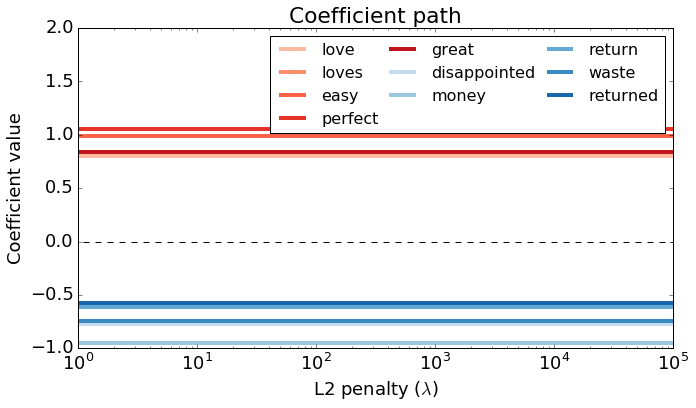

In [65]:
make_coefficient_plot(table, positive_words, negative_words, l2_penalty_list=[0, 4, 10, 1e2, 1e3, 1e5])

Measuring accuracy
Now, let us compute the accuracy of the classifier model. Recall that the accuracy is given by
accuracy=# correctly classified data points# total data points
Recall from lecture that that the class prediction is calculated using
ŷ i={+1−1h(xi)Tw>0h(xi)Tw≤0
Note: It is important to know that the model prediction code doesn't change even with the addition of an L2 penalty. 
      The only thing that changes is the estimated coefficients used in this prediction.
Based on the above, we will use the same code that was used in Module 3 assignment.

In [66]:
def get_classification_accuracy(feature_matrix, sentiment, coefficients):
    scores = np.dot(feature_matrix, coefficients)
    apply_threshold = np.vectorize(lambda x: 1. if x > 0  else -1.)
    predictions = apply_threshold(scores)
    
    num_correct = (predictions == sentiment).sum()
    accuracy = num_correct / len(feature_matrix)    
    return accuracy

Below, we compare the accuracy on the training data and validation data for all the models that were trained in this assignment. We first calculate the accuracy values and then build a simple report summarizing the performance for the various models.

In [68]:
train_accuracy = {}
train_accuracy[0]   = get_classification_accuracy(feature_matrix_train, sentiment_train, coefficients_0_penalty)
train_accuracy[4]   = get_classification_accuracy(feature_matrix_train, sentiment_train, coefficients_4_penalty)
train_accuracy[10]  = get_classification_accuracy(feature_matrix_train, sentiment_train, coefficients_10_penalty)
train_accuracy[1e2] = get_classification_accuracy(feature_matrix_train, sentiment_train, coefficients_1e2_penalty)
train_accuracy[1e3] = get_classification_accuracy(feature_matrix_train, sentiment_train, coefficients_1e3_penalty)
train_accuracy[1e5] = get_classification_accuracy(feature_matrix_train, sentiment_train, coefficients_1e5_penalty)
validation_accuracy = {}
validation_accuracy[0]   = get_classification_accuracy(feature_matrix_valid, sentiment_valid, coefficients_0_penalty)
validation_accuracy[4]   = get_classification_accuracy(feature_matrix_valid, sentiment_valid, coefficients_4_penalty)
validation_accuracy[10]  = get_classification_accuracy(feature_matrix_valid, sentiment_valid, coefficients_10_penalty)
validation_accuracy[1e2] = get_classification_accuracy(feature_matrix_valid, sentiment_valid, coefficients_1e2_penalty)
validation_accuracy[1e3] = get_classification_accuracy(feature_matrix_valid, sentiment_valid, coefficients_1e3_penalty)
validation_accuracy[1e5] = get_classification_accuracy(feature_matrix_valid, sentiment_valid, coefficients_1e5_penalty)

In [69]:
# Build a simple report
for key in sorted(validation_accuracy.keys()):
    print "L2 penalty = %g" % key
    print "train accuracy = %s, validation_accuracy = %s" % (train_accuracy[key], validation_accuracy[key])
    print "--------------------------------------------------------------------------------"

L2 penalty = 0
train accuracy = 0.785156157787, validation_accuracy = 0.78143964149
--------------------------------------------------------------------------------
L2 penalty = 4
train accuracy = 0.785156157787, validation_accuracy = 0.78143964149
--------------------------------------------------------------------------------
L2 penalty = 10
train accuracy = 0.785156157787, validation_accuracy = 0.78143964149
--------------------------------------------------------------------------------
L2 penalty = 100
train accuracy = 0.785156157787, validation_accuracy = 0.78143964149
--------------------------------------------------------------------------------
L2 penalty = 1000
train accuracy = 0.785156157787, validation_accuracy = 0.78143964149
--------------------------------------------------------------------------------
L2 penalty = 100000
train accuracy = 0.785156157787, validation_accuracy = 0.78143964149
--------------------------------------------------------------------------------